In [ ]:
!pip install emcee
!pip install corner
!pip install dynesty
!pip install astroML

In [ ]:
import emcee
import corner
import dynesty
from dynesty import NestedSampler
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity as kde
from sklearn.neighbors import KernelDensity
from astropy import stats as stats_astropy
from astroML import stats as stats_astroML
from scipy import optimize, stats

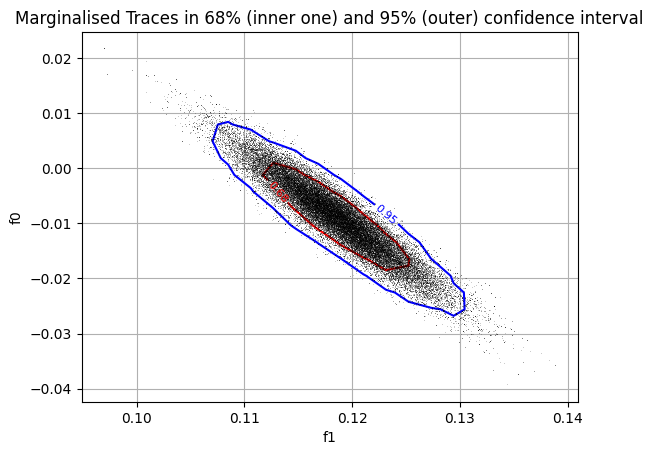

In [ ]:
data = pd.read_csv("fgas_spt.txt",delimiter=' ')
z = data['#z']
f_gas = data["fgas"]
fgas_err = data["fgas_error"]

def log_prior(theta):
   f0 , f1 = theta
   if 0 < f0 < 0.5 and -0.5 < f1 < 0.5:
      return 0.0
   return -np.inf

def log_likelihood(theta, z, f_gas, fgas_err):
   f0, f1 = theta
   model = f0 + f1 * z
   return -0.5 * np.sum(((f_gas - model) / fgas_err)**2)

def log_posterior(theta, z, f_gas, fgas_err):
   return log_prior(theta) + log_likelihood(theta, z, f_gas,fgas_err)

nwalkers = 50
nsteps = 2500 # number of steps
ndim = 2 # number of dimensions
nburn = 1200 # burn-in period

f0_guess = np.random.uniform(0 , 0.5 , nwalkers)
f1_guess = np.random.uniform(-0.5 , 0.5 , nwalkers)
initial = np.vstack((f0_guess , f1_guess)).T

sampler = emcee.EnsembleSampler(nwalkers , ndim , log_posterior , args
= (z , f_gas , fgas_err))
sampler.run_mcmc(initial , nsteps)
samples = sampler.chain[: , nburn: , :].reshape(-1 , ndim)
f0 = samples[:,0].mean()
f1 = samples[:,1].mean()

# plotting marginalised traces

def sigma_level(t1, t2, nbins=20):
 L, xbins, ybins = np.histogram2d(t1, t2, nbins)
 L[L == 0] = 1E-16
 shape = L.shape
 L = L.ravel()
 i_sort = np.argsort(L)[::-1]
 i_unsort = np.argsort(i_sort)
 # cumulative sum
 L_cumsum = L[i_sort].cumsum()
 L_cumsum /= L_cumsum[-1]
 sigma = L_cumsum[i_unsort].reshape(shape)
 xbins = 0.5 * (xbins[1:] + xbins[:-1])
 ybins = 0.5 * (ybins[1:] + ybins[:-1])
 return xbins, ybins, sigma

trace = samples.T
xbins, ybins, sigma = sigma_level(trace[0],trace[1])
contour = plt.contour(xbins, ybins, sigma.T, levels=[0.68, 0.95], colors=['red', 'blue'])
# Optionally, add labels to the contour lines
plt.clabel(contour, inline=True, fontsize=8)

plt.plot(trace[0], trace[1], ',k', alpha=0.2)
plt.title("Marginalised Traces in 68% (inner one) and 95% (outer) confidence interval")
plt.xlabel('f1')
plt.ylabel('f0')
plt.grid()
plt.show()


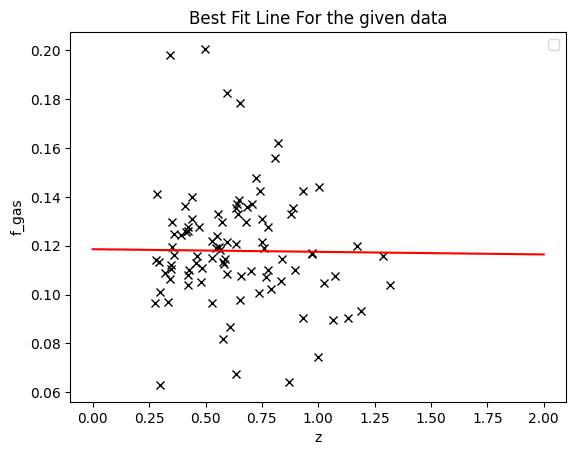

In [ ]:
x = np.linspace(0,2,100)
plt.plot(z , f_gas , 'kx')
plt.xlabel('z')
plt.ylabel('f_gas')
plt.legend()
plt.title("Best Fit Line For the given data")
plt.plot(x , f0 * (1 + f1*x) , 'r-')
plt.show()

68% and 95% joint confidence intervals for f_0 and f_1


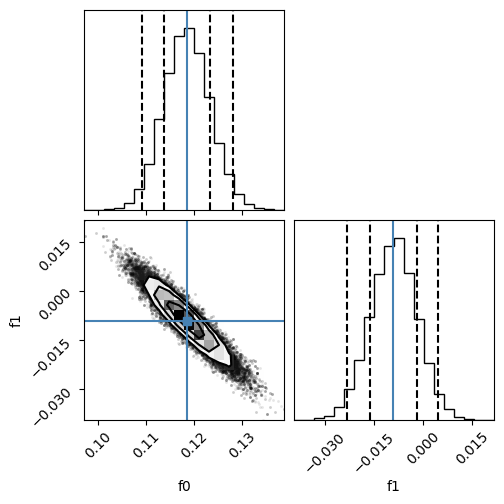

In [ ]:
print("68% and 95% joint confidence intervals for f_0 and f_1")
corner.corner(samples , labels = ["f0" , "f1"] , truths = [f0 , f1] ,
quantiles = (0.16 , 0.84 , 0.025 , 0.975))
plt.show()

In [ ]:
data = np.array([[0.42, 0.72, 0., 0.3, 0.15,0.09, 0.19, 0.35,0.4, 0.54,0.42, 0.69, 0.2, 0.88, 0.03,0.67, 0.42, 0.56,0.14, 0.2],
[0.33, 0.41, -0.22, 0.01, -0.05, -0.05, -0.12,0.26, 0.29, 0.39,0.31, 0.42, -0.01, 0.58, -0.2, 0.52, 0.15, 0.32,-0.13, -0.09],
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,0.1,0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,0.1]])

In [ ]:
x,y,sigma_y = data
# function for polynomial fit
def polynomial_fit(theta):
  sum = 0
  for idx , coeff in enumerate(theta):
     sum += coeff * x ** idx
  return sum
# function for log likelihood
def log_likelyhood(theta, data=data):
  pred = polynomial_fit(theta)
# assumign Gaussian Likelihood
  return -0.5 * np.sum(np.log(2 * np.pi * sigma_y ** 2) + (y - pred)
** 2 / sigma_y ** 2)
# function for prior
def prior(theta):
   return 200*theta - 100


# Taking reference from
# http://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/#dynesty

nlive = 1024 # number of live points
bound = 'multi' # use MutliNest algorithm for bounds
ndims = 2 # two parameters
sample = 'unif' # uniform sampling
tol = 0.1 # the stopping criterion

sampler = NestedSampler(log_likelyhood, prior, ndims,
bound=bound, sample=sample, nlive=nlive)
sampler.run_nested(dlogz=tol, print_progress=False)

res = sampler.results # get results dictionary from sampler
logZdynesty_linear = res.logz[-1] # value of logZ
logZerrdynesty_linear = res.logzerr[-1]

print("log(Z) for the Linear Model = {} ± {}".format(logZdynesty_linear, logZerrdynesty_linear))

# log(Z) for the Linear Model = 7.20169172581548 ± 0.14705550578030252

# Taking reference from
# http://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/#dynesty

nlive = 1024 # number of live points
bound = 'multi' # use MutliNest algorithm for bounds
ndims = 3 # three parameters
sample = 'unif' # uniform sampling
tol = 0.1 # the stopping criterion
sampler = NestedSampler(log_likelyhood, prior, ndims,
bound=bound, sample=sample, nlive=nlive)
sampler.run_nested(dlogz=tol, print_progress=False) # don't output progress bar
res = sampler.results # get results dictionary from sampler
logZdynesty_quadratic = res.logz[-1] # value of logZ
logZerrdynesty_quadratic = res.logzerr[-1] # estimate of the statistcal uncertainty on logZ
print("log(Z) for the Quadratic Model is = {} ±{}".format(logZdynesty_quadratic, logZerrdynesty_quadratic))
print("The Bayes Factor for the quadratic model is given by: {}.\\nThis does not agree with the Blog."\
.format(np.exp(logZdynesty_quadratic) / np.exp(logZdynesty_linear)))


log(Z) for the Linear Model = 6.925929919681063 ± 0.14839103622493907
log(Z) for the Quadratic Model is = 2.4223740744922746 ±0.1719999741438727
The Bayes Factor for the quadratic model is given by: 0.011069564814450197.\nThis does not agree with the Blog.


In [ ]:
!pip install astroML

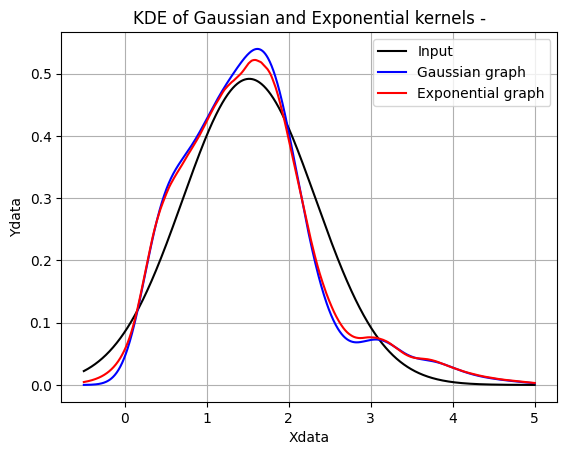

In [ ]:
# importing the input data
dataframe = pd.read_csv('SDSS_quasar.dat',sep = '\s+')
data2 = dataframe['z']
data = data2.to_numpy()

# points on x-axis
x1 = np.linspace(-0.5, 5, 1000)
# input pdf
normal_dist = stats.norm(np.mean(data),np.std(data))
pdf_input = normal_dist.pdf(x_1)
# KDE estimate using gaussian kernel
log_pdf_gaus = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(data[:,np.newaxis]).score_samples(x_1[:,np.newaxis])
pdf_g = np.exp(log_pdf_gaus)
# KDE estimate using exponential kernel
log_pdf_exp = KernelDensity(kernel='exponential', bandwidth=0.2).fit(data[:,np.newaxis]).score_samples(x_1[:,np.newaxis])
pdf_exp = np.exp(log_pdf_exp)
# plot
plt.plot(x1 , pdf_input, 'black', label = 'Input')
plt.plot(x1, pdf_g, 'blue', label = 'Gaussian graph')
plt.plot(x1, pdf_exp, 'red', label = 'Exponential graph')
plt.title('KDE of Gaussian and Exponential kernels -')
plt.xlabel('Xdata')
plt.ylabel('Ydata')
plt.legend()
plt.grid()
plt.show()